In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.use('Agg')

In [2]:
import s3fs
import netCDF4 as nc
import io
import geopy.distance
import re
import pandas as pd
import xarray as xr
import glob
import numpy as np
import copy 
import pytz
from pysolar.solar import *
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.patches as patches
from matplotlib import colors

%matplotlib inline

In [3]:


def date_to_julian_day(date_str):
    # Convert the string to a datetime object
    date = datetime.strptime(date_str, '%Y%m%d').date()
    # Get the Julian day (day of the year)
    julian_day = date.timetuple().tm_yday
    return julian_day



In [4]:
def get_GOES_cloud_mask(julian_day_number,time_hour_input,time_minute_input):
    
    lat_cons=34.7244
    lon_cons=-86.6463
    delta_area=0.5
    

    # Initialize the S3 filesystem
    fs = s3fs.S3FileSystem(anon=True)
    # Specify the target file path
    bucket_name = 'noaa-goes16'
    product = 'ABI-L2-ACMC'
    year = date_str[0:4]
    julian_day = f'{julian_day_number}'
    hour = time_hour_input

    # Construct the S3 path
    prefix = f'{product}/{year}/{julian_day}/{hour}/'
    # List all objects in the specified directory
    files = fs.ls(f'{bucket_name}/{prefix}')
    # Filter and print the list of file names that contain the specific substring
    substring = f'{julian_day}{hour}{time_minute_input}'  # Replace with the actual substring you want to filter by
    filtered_files = [file for file in files if substring in file]
    # Print the filtered list of file names
    for file in filtered_files:
        print(file)

    target_file_path = filtered_files[0]# f'{bucket_name}/{product}/{year}/{julian_day}/{hour}/{target_file}'
    # Full S3 path to the file
    s3_path = f's3://{target_file_path}'

    ###
    # Open the NetCDF file using s3fs
    with fs.open(s3_path, 'rb') as f:
        file_content = f.read()

    # Use io.BytesIO to convert bytes to a file-like object
    file_obj = io.BytesIO(file_content)

    # Open the NetCDF file with xarray using the file-like object
    C_ACM = xr.open_dataset(file_obj, engine='h5netcdf')

    ###
    scan_start_ACM = datetime.strptime(C_ACM.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end_ACM = datetime.strptime(C_ACM.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created_ACM = datetime.strptime(C_ACM.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint_ACM = str(C_ACM['t'].data)[:-8]
    scan_mid_ACM = datetime.strptime(midpoint_ACM, '%Y-%m-%dT%H:%M:%S.%f')
    scan_dur_ACM=((scan_end_ACM-scan_start_ACM).seconds/60)

    scan_start_utc_ACM=scan_start_ACM.hour+scan_start_ACM.minute/60.+scan_start_ACM.second/3600.
    scan_end_utc_ACM=scan_end_ACM.hour+scan_end_ACM.minute/60.+scan_end_ACM.second/3600.
    print('Scan Start    : %s' % scan_start_utc_ACM)
    print('Scan End      : %s' %scan_end_utc_ACM)
    print('Scan Duration : %.2f minutes' % scan_dur_ACM)

    ####
    g16nc=copy.deepcopy(C_ACM)
    proj_info = g16nc.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    latss_ACM = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lonss_ACM = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    ####

    lats_ACM=copy.deepcopy(latss_ACM)
    lons_ACM=copy.deepcopy(lonss_ACM)
    ACM = C_ACM.BCM.values
    ###

    latmin_large=np.nanmin(lat_cons)-delta_area
    latmax_large=np.nanmax(lat_cons)+delta_area
    lonmin_large=np.nanmin(lon_cons)-delta_area
    lonmax_large=np.nanmax(lon_cons)+delta_area

    locv_ACM=np.where(  ( (lons_ACM >= (lonmin_large-delta_area) ) & (lons_ACM <=  (lonmax_large+delta_area) ) ) \
                     &  ( (lats_ACM >= (latmin_large-delta_area)  ) & (lats_ACM <= (latmax_large+delta_area) ) ))

    # most important variable to plot
    xx_ACM=lons_ACM[locv_ACM]
    yy_ACM=lats_ACM[locv_ACM]
    ACM_sub=ACM[locv_ACM]

    ###
    ACM_sub_flip=np.copy(ACM_sub)
    ACM_sub_flip[ACM_sub==1]=0 # cloudy
    ACM_sub_flip[ACM_sub==0]=1 # clear
    cf=np.nansum(ACM_sub[ACM_sub>0])*1.0/len(ACM_sub[ACM_sub>=0])
    print('Cloud Fraction ACM : %s' %cf)

    return xx_ACM,yy_ACM,ACM_sub_flip,cf

# Read GOES reflectance

In [5]:
def get_reflectance_data(julian_day_number,time_hour_input,time_minute_input):
    
    
    # Initialize the S3 filesystem
    fs = s3fs.S3FileSystem(anon=True)
    # Specify the target file path
    bucket_name = 'noaa-goes16'
    product = 'ABI-L2-CMIPC'
    year = date_str[0:4]
    julian_day = f'{julian_day_number}'
    hour = time_hour_input

    # Construct the S3 path
    prefix = f'{product}/{year}/{julian_day}/{hour}/'
    # List all objects in the specified directory
    files = fs.ls(f'{bucket_name}/{prefix}')
    # Filter and print the list of file names that contain the specific substring
    substring = f'M6C02_G16_s{year}{julian_day}{hour}{time_minute_input}'  # Replace with the actual substring you want to filter by
    filtered_files = [file for file in files if substring in file]
    # Print the filtered list of file names
    for file in filtered_files:
        print(file)

    target_file_path = filtered_files[0]# f'{bucket_name}/{product}/{year}/{julian_day}/{hour}/{target_file}'
    s3_path = f's3://{target_file_path}'


    # Open the NetCDF file using s3fs
    with fs.open(s3_path, 'rb') as f:
        file_content = f.read()

    # Use io.BytesIO to convert bytes to a file-like object
    file_obj = io.BytesIO(file_content)

    # Open the NetCDF file with xarray using the file-like object
    C_Red = xr.open_dataset(file_obj, engine='h5netcdf')

    scan_start_Red = datetime.strptime(C_Red.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end_Red = datetime.strptime(C_Red.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created_Red = datetime.strptime(C_Red.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint_Red = str(C_Red['t'].data)[:-8]
    scan_mid_Red = datetime.strptime(midpoint_Red, '%Y-%m-%dT%H:%M:%S.%f')
    scan_dur_Red=((scan_end_Red-scan_start_Red).seconds/60)
    scan_start_utc_Red=scan_start_Red.hour+scan_start_Red.minute/60.+scan_start_Red.second/3600.
    scan_end_utc_Red=scan_end_Red.hour+scan_end_Red.minute/60.+scan_end_Red.second/3600.

    print('Scan Start    : %s' % scan_start_utc_Red)
    print('Scan End      : %s' %scan_end_utc_Red)
    print('Scan Duration : %.2f minutes' % scan_dur_Red)

    #https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    # lat/lon calc routine from satellite radian angle vectors
    g16nc=copy.deepcopy(C_Red)
    proj_info = g16nc.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    # Data info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    latss_Red = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lonss_Red = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)


    lats_Red=copy.deepcopy(latss_Red)
    lons_Red=copy.deepcopy(lonss_Red)
    Red_raw = C_Red.CMI.values

    goes_year=np.int(date_str[0:4])
    goes_month=np.int(date_str[4:6])
    goes_day=np.int(date_str[6:8])
    goes_year,goes_month,goes_day



    time_sza=  np.arange( (12) )+12
    sza=np.zeros( (12) )
    dobj=np.zeros( (12) )
    for k in np.arange(12):
        now_utc = datetime(goes_year,goes_month,goes_day,time_sza[k],tzinfo =pytz.timezone('UTC'))   
        dobj= now_utc.astimezone(pytz.timezone('US/Central'))
        sza[k] = float(90) - get_altitude(lat_cons,lon_cons , dobj)

    f = interp1d(time_sza, sza, fill_value="extrapolate")
    cos_sza=math.cos(f(scan_start_utc_Red)*3.14/180.)
    reflectance = copy.deepcopy(Red_raw/cos_sza)  



    delta_area=0.5
    latmin_large=np.nanmin(lat_cons)-delta_area
    latmax_large=np.nanmax(lat_cons)+delta_area
    lonmin_large=np.nanmin(lon_cons)-delta_area
    lonmax_large=np.nanmax(lon_cons)+delta_area

    locv_Red=np.where(  ( (lons_Red >= (lonmin_large-delta_area) ) & (lons_Red <=  (lonmax_large+delta_area) ) ) \
                     &  ( (lats_Red >= (latmin_large-delta_area)  ) & (lats_Red <= (latmax_large+delta_area) ) ))
    xx_Red=lons_Red[locv_Red]
    yy_Red=lats_Red[locv_Red]
    Red_sub=reflectance[locv_Red]


    return xx_Red,yy_Red,Red_sub,latss_Red,lonss_Red

# Add Brightness Temperature

In [6]:
def get_Brightness_Temperature_data(julian_day_number,time_hour_input,time_minute_input):
    
    # Initialize the S3 filesystem
    fs = s3fs.S3FileSystem(anon=True)
    # Specify the target file path
    bucket_name = 'noaa-goes16'    
    product = 'ABI-L2-CMIPC'  # Cloud Optical Depth product # No full disk before end of 2019, but have data for CONUS
    year = date_str[0:4]
    julian_day = f'{julian_day_number}'
    hour = time_hour_input
    # Construct the S3 path
    prefix = f'{product}/{year}/{julian_day}/{hour}/'#/
    # List all objects in the specified directory
    files = fs.ls(f'{bucket_name}/{prefix}/')
    # Filter and print the list of file names that contain the specific substring
    substring = f'M6C14_G16_s{year}{julian_day}{hour}{time_minute_input}'  
    filtered_files = [file for file in files if substring in file]
    target_file_path = filtered_files[0]# f'{bucket_name}/{product}/{year}/{julian_day}/{hour}/{target_file}'
    # Full S3 path to the file
    s3_path = f's3://{target_file_path}'


    # Open the NetCDF file using s3fs
    with fs.open(s3_path, 'rb') as f:
        file_content = f.read()

    # Use io.BytesIO to convert bytes to a file-like object
    file_obj = io.BytesIO(file_content)

    # Open the NetCDF file with xarray using the file-like object
    C_ACM = xr.open_dataset(file_obj, engine='h5netcdf')

    

    scan_start_ACM = datetime.strptime(C_ACM.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end_ACM = datetime.strptime(C_ACM.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created_ACM = datetime.strptime(C_ACM.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint_ACM = str(C_ACM['t'].data)[:-8]
    scan_mid_ACM = datetime.strptime(midpoint_ACM, '%Y-%m-%dT%H:%M:%S.%f')
    scan_dur_ACM=((scan_end_ACM-scan_start_ACM).seconds/60)
    scan_start_utc_ACM=scan_start_ACM.hour+scan_start_ACM.minute/60.+scan_start_ACM.second/3600.
    scan_end_utc_ACM=scan_end_ACM.hour+scan_end_ACM.minute/60.+scan_end_ACM.second/3600.

    ###
    #https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    # lat/lon calc routine from satellite radian angle vectors
    g16nc=copy.deepcopy(C_ACM)
    proj_info = g16nc.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    # Data info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    latss_ACM = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lonss_ACM = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    lats_ACM=copy.deepcopy(latss_ACM)
    lons_ACM=copy.deepcopy(lonss_ACM)
    ACM = C_ACM.CMI.values #at channel 14


    lat_cons=34.7244
    lon_cons=-86.6463
    delta_area=0.5

    latmin_large=np.nanmin(lat_cons)-delta_area
    latmax_large=np.nanmax(lat_cons)+delta_area
    lonmin_large=np.nanmin(lon_cons)-delta_area
    lonmax_large=np.nanmax(lon_cons)+delta_area

    locv_ACM=np.where(  ( (lons_ACM >= (lonmin_large-delta_area) ) & (lons_ACM <=  (lonmax_large+delta_area) ) ) \
                     &  ( (lats_ACM >= (latmin_large-delta_area)  ) & (lats_ACM <= (latmax_large+delta_area) ) ))


    xx_ACM=lons_ACM[locv_ACM]
    yy_ACM=lats_ACM[locv_ACM]
    ACM_sub=ACM[locv_ACM]

    return xx_ACM,yy_ACM,ACM_sub

# Added COD

In [7]:
def get_COD_data(julian_day_number,time_hour_input,time_minute_input):
    
    # Initialize the S3 filesystem
    fs = s3fs.S3FileSystem(anon=True)
    # Specify the target file path
    bucket_name = 'noaa-goes16'    
    product = 'ABI-L2-CODC'  # Cloud Optical Depth product # No full disk before end of 2019, but have data for CONUS
    #product = 'ABI-L2-ACMC'
    year = date_str[0:4]
    julian_day = f'{julian_day_number}'
    hour = time_hour_input
    # Construct the S3 path
    prefix = f'{product}/{year}/{julian_day}/{hour}/'#/
    # List all objects in the specified directory
    files = fs.ls(f'{bucket_name}/{prefix}/')
    # Filter and print the list of file names that contain the specific substring
    substring = f'_s{year}{julian_day}{hour}{time_minute_input}'  # Replace with the actual substring you want to filter by
    filtered_files = [file for file in files if substring in file]
    target_file_path = filtered_files[0]# f'{bucket_name}/{product}/{year}/{julian_day}/{hour}/{target_file}'
    # Full S3 path to the file
    s3_path = f's3://{target_file_path}'


    # Open the NetCDF file using s3fs
    with fs.open(s3_path, 'rb') as f:
        file_content = f.read()

    # Use io.BytesIO to convert bytes to a file-like object
    file_obj = io.BytesIO(file_content)

    # Open the NetCDF file with xarray using the file-like object
    C_ACM = xr.open_dataset(file_obj, engine='h5netcdf')

    

    scan_start_ACM = datetime.strptime(C_ACM.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    scan_end_ACM = datetime.strptime(C_ACM.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    file_created_ACM = datetime.strptime(C_ACM.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')
    midpoint_ACM = str(C_ACM['t'].data)[:-8]
    scan_mid_ACM = datetime.strptime(midpoint_ACM, '%Y-%m-%dT%H:%M:%S.%f')
    scan_dur_ACM=((scan_end_ACM-scan_start_ACM).seconds/60)
    scan_start_utc_ACM=scan_start_ACM.hour+scan_start_ACM.minute/60.+scan_start_ACM.second/3600.
    scan_end_utc_ACM=scan_end_ACM.hour+scan_end_ACM.minute/60.+scan_end_ACM.second/3600.

    ###
    #https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    # lat/lon calc routine from satellite radian angle vectors
    g16nc=copy.deepcopy(C_ACM)
    proj_info = g16nc.goes_imager_projection
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis
    # Data info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)
    latss_ACM = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lonss_ACM = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    lats_ACM=copy.deepcopy(latss_ACM)
    lons_ACM=copy.deepcopy(lonss_ACM)
    ACM = C_ACM.COD.values 


    lat_cons=34.7244
    lon_cons=-86.6463
    delta_area=0.5

    latmin_large=np.nanmin(lat_cons)-delta_area
    latmax_large=np.nanmax(lat_cons)+delta_area
    lonmin_large=np.nanmin(lon_cons)-delta_area
    lonmax_large=np.nanmax(lon_cons)+delta_area

    locv_ACM=np.where(  ( (lons_ACM >= (lonmin_large-delta_area) ) & (lons_ACM <=  (lonmax_large+delta_area) ) ) \
                     &  ( (lats_ACM >= (latmin_large-delta_area)  ) & (lats_ACM <= (latmax_large+delta_area) ) ))


    xx_ACM=lons_ACM[locv_ACM]
    yy_ACM=lats_ACM[locv_ACM]
    ACM_sub=ACM[locv_ACM]

    return xx_ACM,yy_ACM,ACM_sub

# Figure 1

In [8]:
# Example date string
date_str = '20210705'
# Get the Julian day
julian_day_number = date_to_julian_day(date_str)
print(julian_day_number)

time_hour_input='17'
time_minute_input='01'
time_input_float=17.

186


In [9]:
lat_cons=34.7244
lon_cons=-86.6463
delta_area=0.5

latmin=lat_cons-delta_area
latmax=lat_cons+delta_area
lonmin=lon_cons-delta_area
lonmax=lon_cons+delta_area

In [10]:
from datetime import datetime, timedelta

xx_ACM,yy_ACM,ACM_sub_flip,cf_ACM=get_GOES_cloud_mask(julian_day_number,time_hour_input,time_minute_input)
xx_Red,yy_Red,Red_sub,latss_Red,lonss_Red=get_reflectance_data(julian_day_number,time_hour_input,time_minute_input)
xx_BT,yy_BT,BT_sub=get_Brightness_Temperature_data(julian_day_number,time_hour_input,time_minute_input)
xx_COD,yy_COD,COD_sub=get_COD_data(julian_day_number,time_hour_input,time_minute_input)


noaa-goes16/ABI-L2-ACMC/2021/186/17/OR_ABI-L2-ACMC-M6_G16_s20211861701171_e20211861703544_c20211861704321.nc
Scan Start    : 17.02138888888889
Scan End      : 17.065
Scan Duration : 2.62 minutes
Cloud Fraction ACM : 0.37685545467646636
noaa-goes16/ABI-L2-CMIPC/2021/186/17/OR_ABI-L2-CMIPC-M6C02_G16_s20211861701171_e20211861703544_c20211861704043.nc
Scan Start    : 17.02138888888889
Scan End      : 17.065
Scan Duration : 2.62 minutes


In [11]:
lats_array = copy.deepcopy(latss_Red)
lons_array = copy.deepcopy(lonss_Red)

solutions = np.argwhere(  ( (lons_array >= lonmin) & (lons_array <= lonmax) )   \
                        & ( (lats_array >= latmin) & (lats_array <= latmax) )  ) \


index_lon=solutions[:,0]
index_lat=solutions[:,1]

min_lon_index=np.min(index_lon)
max_lon_index=np.max(index_lon)
min_lat_index=np.min(index_lat)
max_lat_index=np.max(index_lat)

num_lon=-np.min(index_lon)+np.max(index_lon)+1
num_lat=-np.min(index_lat)+np.max(index_lat)+1
    
    
#print(num_lon,num_lat)

lats_n = latss_Red[min_lon_index:max_lon_index+1,min_lat_index:max_lat_index+1]
lons_n = lonss_Red[min_lon_index:max_lon_index+1,min_lat_index:max_lat_index+1]

print(lats_n.shape)

(167, 200)


In [12]:
# Load the NetCDF file
loaded_ds = xr.load_dataset('./Data/CF_SEUS_data.nc')

# Access data variables
cf_Red = loaded_ds['cf_Red'].values
cf_CMask = loaded_ds['cf_CMask'].values

lons_n = loaded_ds['lons_n'].values
lats_n = loaded_ds['lats_n'].values
GOES_Flag_0045_flip = loaded_ds['GOES_Flag_0045_flip'].values




In [13]:
delta_area=0.45

latmin_large=np.nanmin(lat_cons)-delta_area
latmax_large=np.nanmax(lat_cons)+delta_area
lonmin_large=np.nanmin(lon_cons)-delta_area
lonmax_large=np.nanmax(lon_cons)+delta_area

97


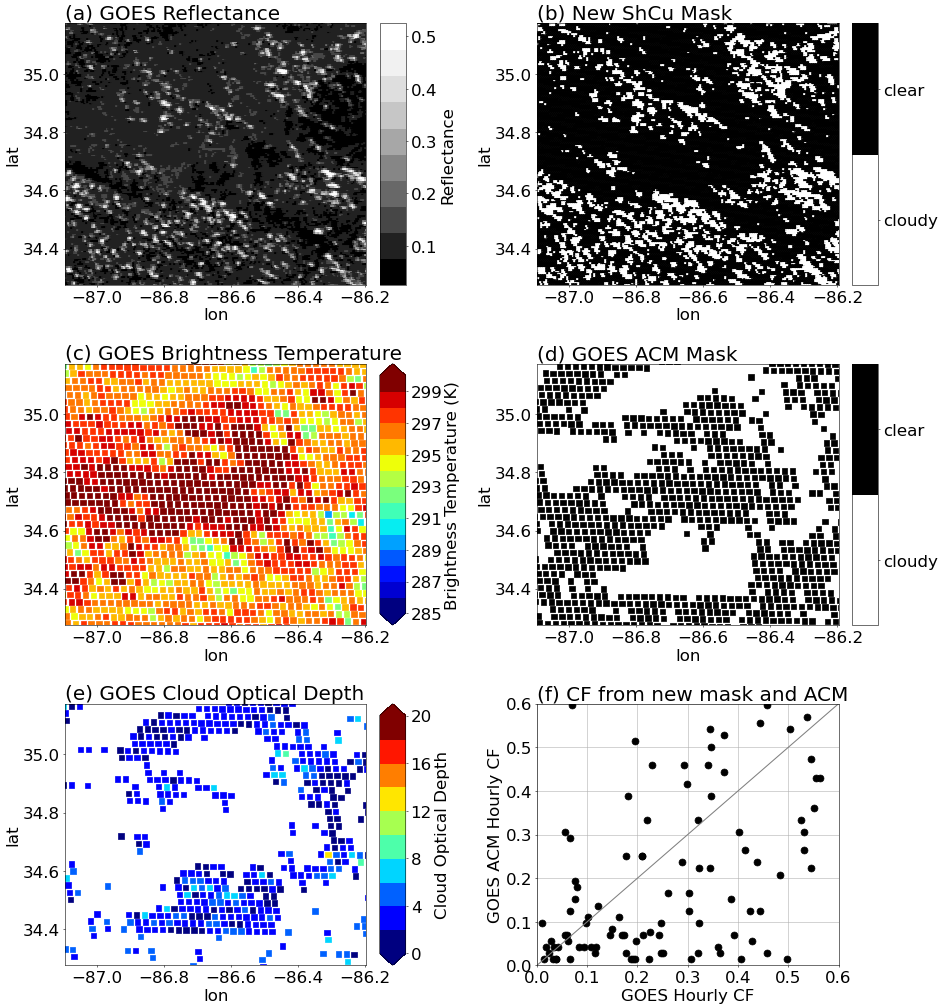

In [14]:

mpl.rcParams['font.size'] = 24
mpl.rcParams['font.weight'] = 'regular'
mpl.rcParams['font.family'] = 'DejaVu Sans'
fig = plt.figure(figsize=[22,24], dpi=50)


gs = gridspec.GridSpec(3, 22)
gs.update(wspace=0.5, hspace=0.3, top=0.91)

ax1 = plt.subplot(gs[0,0:8])
cax1 = plt.subplot(gs[0,8:9])

ax2 = plt.subplot(gs[0,12:20])
cax2 = plt.subplot(gs[0,20:21])


ax3 = plt.subplot(gs[1,0:8])
cax3 = plt.subplot(gs[1,8:9])

ax4 = plt.subplot(gs[1,12:20])
cax4 = plt.subplot(gs[1,20:21])

ax5 = plt.subplot(gs[2,0:8])
cax5 = plt.subplot(gs[2,8:9])

ax6 = plt.subplot(gs[2,12:20])


####Reflectance####
cmap = plt.get_cmap('Greys_r')
#bounds = np.arange(0., 1.1, 0.1)
bounds = np.arange(0.025, 0.55, 0.05)
bounds[0]=0.05
norm = colors.BoundaryNorm(bounds, cmap.N)

c1=ax1.scatter(xx_Red,yy_Red,c=Red_sub,marker='s',cmap=cmap,norm=norm,s=20)#s=50

ax1.set_xlim(lonmin_large,lonmax_large)
ax1.set_ylim(latmin_large,latmax_large)
ax1.set_xlabel('lon')
ax1.set_ylabel('lat')
cb1 = Colorbar(mappable=c1, ax=cax1, orientation='vertical')
cb1.set_ticks([0.1, 0.2, 0.3, 0.4,0.5])
cb1.set_label('Reflectance')
ax1.set_title('(a) GOES Reflectance', loc='left');



cmap = plt.get_cmap('binary')
bounds=np.arange( 3 )*1
norm = colors.BoundaryNorm(bounds, cmap.N)

c2=ax2.scatter(lons_n, lats_n,  cmap=cmap,norm=norm, marker='s',c=GOES_Flag_0045_flip,s=10)#,s=area_plot2
ax2.set_title('(b) New ShCu Mask', loc='left');
ax2.set_xlabel('lon')
ax2.set_ylabel('lat')
ax2.set_xlim(lonmin_large,lonmax_large)
ax2.set_ylim(latmin_large,latmax_large)
cb2 = Colorbar(mappable=c2, ax=cax2, orientation='vertical',ticks=np.arange(2)+0.5)
cb2.set_ticklabels(['cloudy', 'clear'])



cmap = plt.get_cmap('jet')
bounds = np.arange(285., 301., 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

c3=ax3.scatter(xx_BT,yy_BT,c=BT_sub,cmap=cmap,marker='s',norm=norm,s=60)#
ax3.set_xlim(lonmin_large,lonmax_large)
ax3.set_ylim(latmin_large,latmax_large)
ax3.set_xlabel('lon')
ax3.set_ylabel('lat')
cb3 = Colorbar(mappable=c3, ax=cax3, orientation='vertical',extend='both')
cb3.set_label('Brightness Temperature (K)')
ax3.set_title('(c) GOES Brightness Temperature', loc='left');


cmap = plt.get_cmap('binary')
bounds=np.arange( 3 )*1
norm = colors.BoundaryNorm(bounds, cmap.N)

c4=ax4.scatter(xx_ACM,yy_ACM,c=ACM_sub_flip,cmap='binary',marker='s',norm=norm,s=60)#
ax4.set_xlim(lonmin_large,lonmax_large)
ax4.set_ylim(latmin_large,latmax_large)
ax4.set_xlabel('lon')
ax4.set_ylabel('lat')
cb4 = Colorbar(mappable=c4, ax=cax4, orientation='vertical',ticks=np.arange(2)+0.5)
ax4.set_title('(d) GOES ACM Mask', loc='left');
cb4.set_ticklabels(['cloudy', 'clear'])


cmap = plt.get_cmap('jet')
bounds = np.arange(0., 21., 2)
norm = colors.BoundaryNorm(bounds, cmap.N)

c5=ax5.scatter(xx_COD,yy_COD,c=COD_sub,cmap=cmap,marker='s',norm=norm,s=60)#
ax5.set_xlim(lonmin_large,lonmax_large)
ax5.set_ylim(latmin_large,latmax_large)
ax5.set_xlabel('lon')
ax5.set_ylabel('lat')
cb5 = Colorbar(mappable=c5, ax=cax5, orientation='vertical',extend='both')
cb5.set_label('Cloud Optical Depth')
ax5.set_title('(e) GOES Cloud Optical Depth', loc='left');


####
loc=np.where((cf_Red>0) & (cf_CMask>0)  & (cf_Red<=0.6) & (cf_CMask<=0.6)  )
print(loc[0].shape[0])

ax6.plot(cf_Red[loc],\
         cf_CMask[loc],'o',color='black',markersize=10)


# Plot the y = x line
ax6.plot([0, 1.0], [0, 1.0], color='grey')

ax6.grid()

ax6.set_xlim(0, 0.6)
ax6.set_ylim(0, 0.6)

ax6.set_xlabel('GOES Hourly CF')
ax6.set_ylabel('GOES ACM Hourly CF')

ax6.set_title('(f) CF from new mask and ACM', loc='left');

#fig.savefig(f'./Figure1_ACM_{date_str}.png', dpi=300, bbox_inches='tight')
